# Fitting system VI

Author: G. P. Fedorov (gleb.fedorov@phystech.edu), https://github.com/vdrhtc/XMons

In [1]:
%pylab inline 

Populating the interactive namespace from numpy and matplotlib


In [2]:
def spines(ax = None):
    if ax == None:
        ax = plt.gca()
    dict(ax.spines.items())["left"].set_position(('outward', 10))
    dict(ax.spines.items())["bottom"].set_position(('outward', 10))
    dict(ax.spines.items())["top"].set_position(('outward', 10))
    dict(ax.spines.items())["right"].set_position(('outward', 10))
    
def annotate_distance(ax, text, point1, point2, linestyle, fontsize, textoffset = (0.1,0)):
    ax.annotate('', point1, point2, \
            arrowprops={'arrowstyle':'<->', 'linestyle':linestyle, "facecolor":"black"}, fontsize=fontsize);
    ax.annotate(text, point1, (0.5*(point1[0]+point2[0])+textoffset[0], 0.5*(point1[1]+point2[1])+textoffset[1]),
                fontsize=fontsize)

In [3]:
from scipy import *
from scipy.constants import e, h, hbar
from qutip import *
import pickle

Capacitances and other parameters:

In [4]:
font = {"size":20}
matplotlib.rc("font", **font)

In [5]:
C_κ = 0e-15
C_g = 1.8e-15
C_q = 95e-15
res_factor = 1.4582
C_r = 251.9e-15*res_factor
L_r = 9.737e-10*res_factor
Φ = 0 # in Φ_0
ν_q = 6.902
def C_ast():
    return sqrt(C_q*C_g+C_q*C_κ+C_g*C_κ+C_q*C_r+C_g*C_r)
def E_C():
    return (e)**2*(C_g+C_κ+C_r)/2/C_ast()**2/h/1e9
def E_J():
    return (ν_q*1e9+E_C()*1e9)**2/8/(e)**2/(C_g+C_κ+C_r)*2*C_ast()**2*h**2/h/1e9*cos(pi*Φ)
def ω_r():
    return 1/sqrt(L_r*C_ast()**2/(C_q+C_g))

In [6]:
E_J(), E_J()*h*1e9, E_J()/E_C(), ω_r()/1e9/2/pi, E_C(), C_r, L_r

(31.50559635844321,
 2.0875828812301365e-23,
 157.43051524442654,
 6.9523969639166721,
 0.20012382167159673,
 3.6732058e-13,
 1.41984934e-09)

In [7]:
N_q = 15
N_r = 8
n_g = 0

In [8]:
def a():
    return destroy(N_r)
def n():
    return Qobj((diag(arange(-N_q, N_q+1, 1))))

def H_q_isolated():
    H_q = 4*E_C()*n()**2+ E_J()/2*(Qobj(diag(ones(2*N_q), 1) + diag(ones(2*N_q), -1)))
    return H_q
def H_q():
    return tensor(identity(N_r), H_q_isolated())

def H_r():
    H_r = ω_r()/2/pi/1e9*(a().dag()*a()+1/2)
    return tensor(H_r, identity(2*N_q+1))
def g():
    return 2*e*C_g/C_ast()*sqrt(hbar*ω_r()/2/(C_q+C_g))/h/1e9
def H_i():
    return g()*1j*tensor(a().dag()-a(), n())

def H():
    return H_q()+H_r()+H_i()

In [9]:
E_0 = H().eigenenergies()[0]
evals = []
Φs = linspace(-0.25, 0.25, 41)
for Φ in Φs:
    print("\rΦ:", Φ, flush=True, end="")
    evals.append(H().eigenenergies())
evals = array(evals)

Φ: 0.25

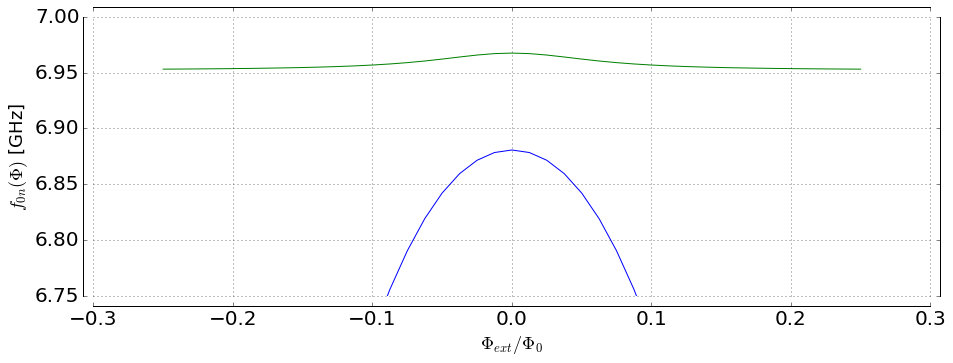

In [10]:
for i in range(1, 20):
    plt.plot(Φs, (evals[:, i]-evals[:,0]))
#plt.xlim(-0.5, 0.5)
plt.ylim(6.75, 7)
spines()

plt.ylabel("$f_{0n}(\Phi)$ [GHz]", fontsize=18)
plt.xlabel("$\Phi_{ext}/\Phi_0$", fontsize=18)
plt.grid()
plt.gcf().set_size_inches(15,5)
# plt.savefig("freqs.pdf", bbox_inches='tight')

# Anticrossing

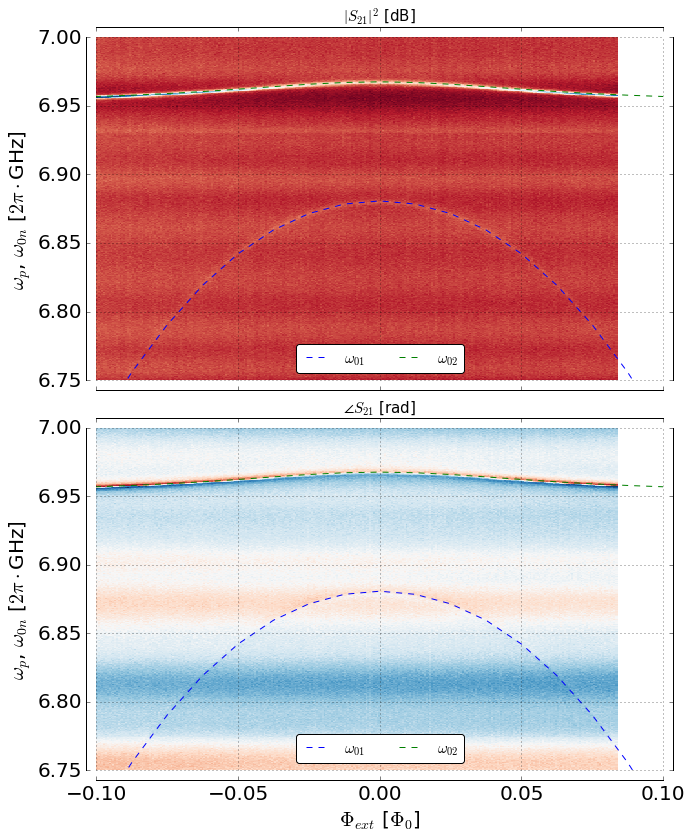

In [11]:
with open("fitting_data/xmons-first-try-6th-res-anticrossing-calibrated.pkl", "rb") as f:
    data = pickle.load(f)
exp_Φs = data[0]
exp_freqs = data[1]
exp_amps = data[2].T
exp_phas = data[3].T

fig, axes = plt.subplots(2, 1, figsize = (10,12))

for ax in axes:
    ax.plot(Φs, (evals[:, 1]-evals[:,0]), '--', label = "$\omega_{01}$")
    ax.plot(Φs, (evals[:, 2]-evals[:,0]), '--', label = "$\omega_{02}$")

# plt.plot(Φs, (evals[:, 3]-evals[:,0])/2, '--', label = "$\omega_{03}/2$")
# plt.plot(Φs, (evals[:, 4]-evals[:,0])/2, '--', label = "$\omega_{04}/2$")
# plt.plot(Φs, (evals[:, 5]-evals[:,0])/2, '--',  label = "$\omega_{05}/2$")
# plt.plot(Φs, (evals[:, 6]-evals[:,0])/3, '--', label = "$\omega_{08}/2$")
# plt.plot(Φs, (evals[:, 7]-evals[:,0])/3, '--', label = "$\omega_{07}/2$")
# plt.plot(Φs, (evals[:, 8]-evals[:,0])/3, ':', label = "$\omega_{08}/2$")
# plt.plot(Φs, (evals[:, 9]-evals[:,0])/3, ':', label = "$\omega_{09}/2$")


mesh_amps = axes[0].pcolormesh(exp_Φs, exp_freqs/1e9, exp_amps, cmap='RdBu_r', rasterized=True)
mesh_phas = axes[1].pcolormesh(exp_Φs, exp_freqs/1e9, exp_phas, cmap='RdBu_r', rasterized=True)

for ax in axes:
    ax.set_xticks(linspace(-0.1, 0.1, 5))
    spines(ax)
    ax.set_xlim(-0.1, 0.1)
    ax.set_ylim(6.75, 7)
    ax.set_ylabel("$\omega_p$, $\omega_{0n}$ [$2\pi\cdot$GHz]")
    plt.xlabel("$\Phi_{ext}$ [$\Phi_0$]")
    ax.grid()
    ax.legend(ncol=2,loc=8, fontsize=15, fancybox=True)

axes[0].set_xticklabels([])
    
axes[0].set_title(r"$|S_{21}|^2$ [dB]", fontsize=15, y=1.03)
axes[1].set_title(r"$\angle S_{21}$ [rad]", fontsize=15, y=1.03)
plt.tight_layout(h_pad=0.5)

plt.savefig("anticrossing_fit.pdf", bbox_inches='tight')

## 2tone spectrum

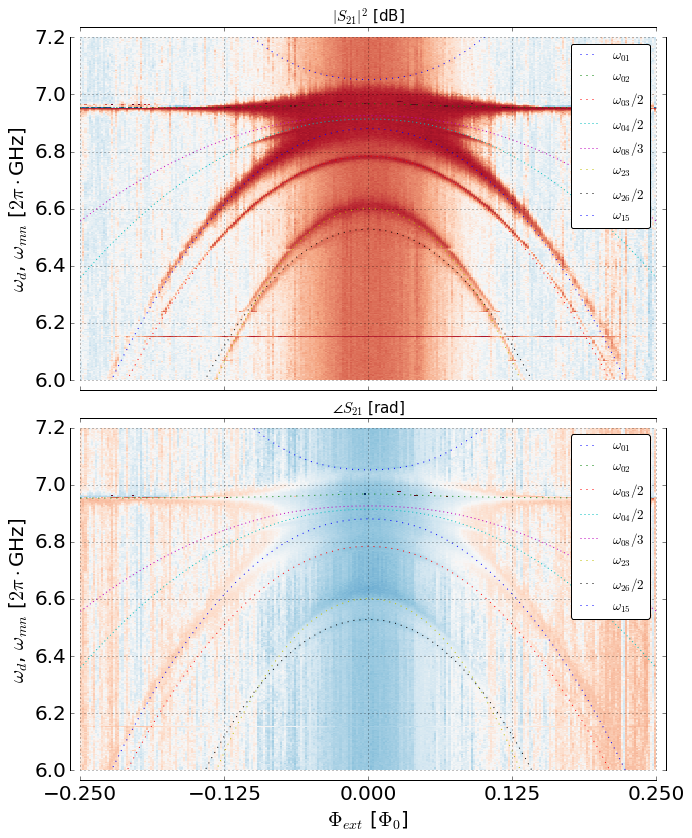

In [12]:
with open("fitting_data/xmons-first-try-6th-res-2tone-calibrated.pkl", "rb") as f:
    data2 = pickle.load(f)

exp_Φs = data2[0]
exp_freqs = data2[1]
exp_amps = data2[2].T
exp_phas = data2[3].T

fig, axes = plt.subplots(2, 1, figsize = (10,12))
for ax in axes:
    ax.plot(Φs, (evals[:, 1]-evals[:,0]), ':', label = "$\omega_{01}$",dashes=[1, 5])
    ax.plot(Φs, (evals[:, 2]-evals[:,0]), ':', label = "$\omega_{02}$",dashes=[1, 5])

    ax.plot(Φs, (evals[:, 3]-evals[:,0])/2, ':', label = "$\omega_{03}/2$",dashes=[1, 5])
    ax.plot(Φs, (evals[:, 4]-evals[:,0])/2, ':', label = "$\omega_{04}/2$")
#     ax.plot(Φs, (evals[:, 5]-evals[:,0])/2, ':',  label = "$\omega_{05}/2$",dashes=[1, 5])
    ax.plot(Φs, (evals[:, 8]-evals[:,0])/3, ':', label = "$\omega_{08}/3$")

    ax.plot(Φs, (evals[:, 3]-evals[:,2]), ':', label = "$\omega_{23}$",dashes=[1, 5])
    ax.plot(Φs, (evals[:, 6]-evals[:,2])/2, ':', label = "$\omega_{26}/2$",dashes=[1, 5])

    ax.plot(Φs, (evals[:, 5]-evals[:,1]), ':',  label = "$\omega_{15}$",dashes=[1, 5])

axes[0].pcolormesh(exp_Φs*1.01, exp_freqs/1e9, exp_amps, cmap='RdBu_r', rasterized=True, vmax=-32, vmin=-38)
axes[1].pcolormesh(exp_Φs*1.01, exp_freqs/1e9, exp_phas, cmap='RdBu_r', rasterized=True, vmax=-2)


for ax in axes:
    
    ax.set_xticks(linspace(-0.25, 0.25, 5))

    spines(ax)

    ax.set_xlim(-0.25, 0.25)
    ax.set_ylim(6, 7.2001)


    ax.set_ylabel("$\omega_d$, $\omega_{mn}$ [$2\pi\cdot$GHz]")
    plt.xlabel("$\Phi_{ext}$ [$\Phi_0$]")
    ax.grid()

    ax.legend(ncol=1,loc=1, fontsize=13, fancybox=True)
axes[0].set_xticklabels([])
axes[0].set_title(r"$|S_{21}|^2$ [dB]", fontsize=15, y=1.03)
axes[1].set_title(r"$\angle S_{21}$ [rad]", fontsize=15, y=1.03)
plt.tight_layout(h_pad=0.5)
plt.savefig("2tone_fit.pdf", bbox_inches='tight')